# Image Classification of Animals
This notebook implements an image classification system for identifying animals using a pre-trained MobileNetV2 model.

In [ ]:

# Import required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image


In [3]:

import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
dataset_dir = 'dataset'
train_dir = 'dataset_split/train'
test_dir = 'dataset_split/test'

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all class folders
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Split data for each class
for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    # Split into train and test
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create class subdirectories in train/test folders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    
    # Move images to train directory
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    
    # Move images to test directory
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

# Data Generators
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



Found 1549 images belonging to 15 classes.
Found 395 images belonging to 15 classes.


In [4]:

# Model definition using MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')  # 15 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


9406464/9406464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 18,318,415
Trainable params: 16,060,431
Non-t

In [6]:

# Training the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)


Epoch 1/10
49/49 [==============================] - 41s 801ms/step - loss: 3.4299 - accuracy: 0.4842 - val_loss: 0.7461 - val_accuracy: 0.7418
Epoch 2/10
49/49 [==============================] - 34s 698ms/step - loss: 1.0820 - accuracy: 0.6733 - val_loss: 0.6423 - val_accuracy: 0.8101
Epoch 3/10
49/49 [==============================] - 34s 699ms/step - loss: 0.9178 - accuracy: 0.7385 - val_loss: 0.5635 - val_accuracy: 0.8278
Epoch 4/10
49/49 [==============================] - 35s 711ms/step - loss: 0.8508 - accuracy: 0.7527 - val_loss: 0.4932 - val_accuracy: 0.8759
Epoch 5/10
49/49 [==============================] - 35s 707ms/step - loss: 0.6976 - accuracy: 0.8096 - val_loss: 0.4364 - val_accuracy: 0.8759
Epoch 6/10
49/49 [==============================] - 38s 772ms/step - loss: 0.6602 - accuracy: 0.7986 - val_loss: 0.5073 - val_accuracy: 0.8304
Epoch 7/10
49/49 [==============================] - 34s 703ms/step - loss: 0.6427 - accuracy: 0.8057 - val_loss: 0.4311 - val_accuracy: 0.8709

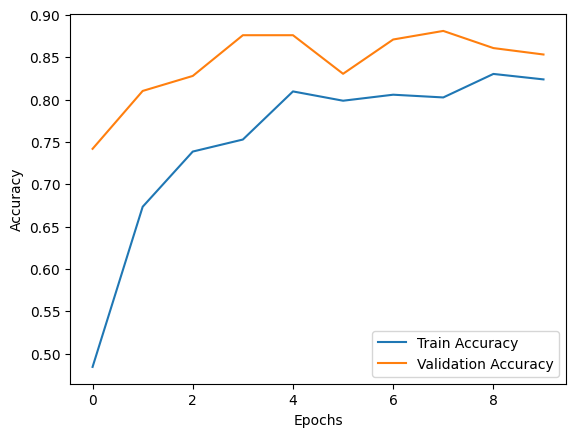

In [7]:

# Visualizing training results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [8]:

# Testing the model
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


Found 395 images belonging to 15 classes.
13/13 [==============================] - 6s 422ms/step - loss: 0.4759 - accuracy: 0.8532
Test Accuracy: 0.85


In [9]:

# Save the model
model.save('animal_classifier.h5')


In [14]:

# Inference example
model = tf.keras.models.load_model('animal_classifier.h5')

img_path = 'dataset/Horse/Horse_1_2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
class_indices = {v: k for k, v in train_generator.class_indices.items()}
print(f"Predicted Class: {class_indices[np.argmax(prediction)]}")


1/1 [==============================] - 4s 4s/step
Predicted Class: Horse
